In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow.keras import layers, models 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sb

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [4]:
df = tf.keras.preprocessing.image_dataset_from_directory("dataset\\PLD_5_Classes_256\\Training",shuffle=True,image_size= (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size= BATCH_SIZE)

Found 6034 files belonging to 5 classes.


In [5]:
class_names = df.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight', 'Non_Potato', 'Object']

In [6]:
len(df) #no.of imgs/batch size

189

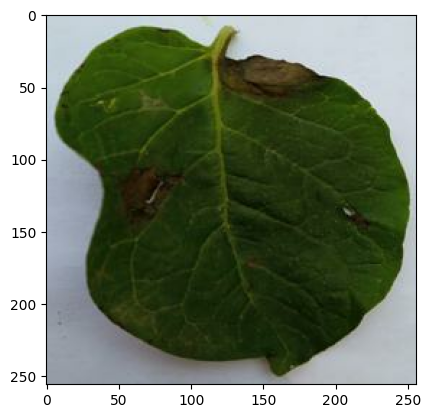

In [7]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

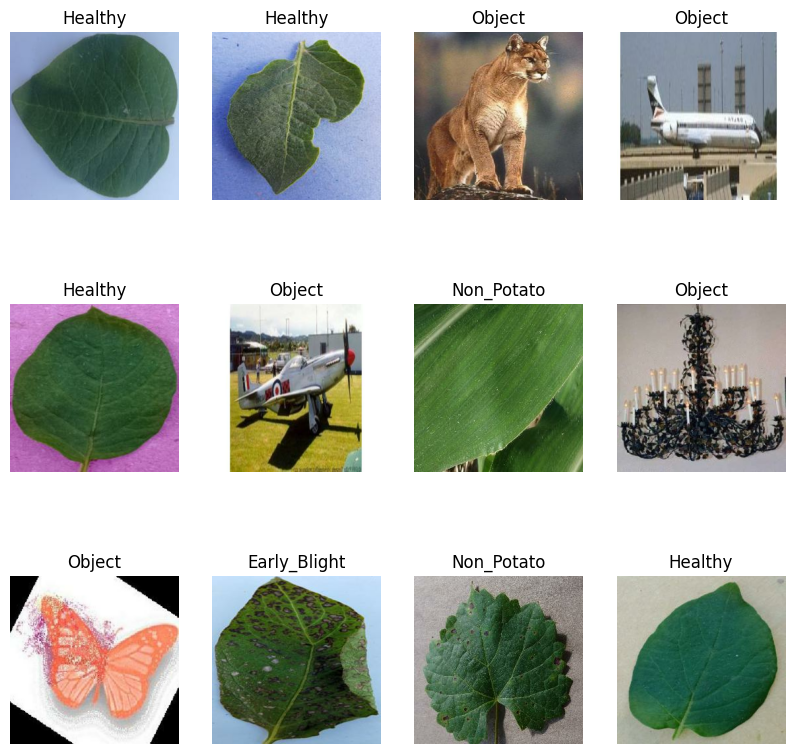

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
CHANNELS = 3
EPOCHS = 42

In [10]:
train_size = 0.8
len(df) * train_size  #126*0.8

151.20000000000002

In [11]:
val_n_test = len(df) - (len(df) * train_size)
val_n_test

37.79999999999998

In [12]:
def split_datasets(pc,train_split = 0.8,val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    if shuffle:
        pc = pc.shuffle(shuffle_size,seed = 10)
        
    pc_size = len(pc) 
    train_size = int(train_split*pc_size)
    val_size = int(val_split*pc_size)
    
    train_pc = pc.take(train_size) 
    val_pc = pc.skip(train_size).take(val_size) 
    test_pc = pc.skip(train_size).skip(val_size) 
                                        
    
    return train_pc, val_pc, test_pc

In [13]:
train_data, val_data, test_data = split_datasets(df)


In [14]:
print("Size of Data is :{0} \nBatch Size of Training Data is :{1} \nBatch Size of Validation Data :{2} \nBatch Size of Test Data :{3}"
      .format(len(df), len(train_data), len(val_data), len(test_data)))

Size of Data is :189 
Batch Size of Training Data is :151 
Batch Size of Validation Data :18 
Batch Size of Test Data :20


In [15]:
train_pc = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pc = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_pc = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
rescale_n_resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    tf.keras.layers.Rescaling(1./255)  
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), 
    tf.keras.layers.RandomRotation(factor=0.5)  
])

In [17]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    layers.Input(input_shape),
    rescale_n_resize,
    data_augmentation,
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.build(input_shape=(None, *input_shape))


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,565 (1.29 MB)

 Trainable params: 338,565 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [20]:















history = model.fit(train_data, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose=1)

Epoch 1/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.4854 - loss: 1.1573 - val_accuracy: 0.6979 - val_loss: 0.7378
Epoch 2/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.6693 - loss: 0.7619 - val_accuracy: 0.7413 - val_loss: 0.6311
Epoch 3/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7478 - loss: 0.6393 - val_accuracy: 0.8212 - val_loss: 0.4337
Epoch 4/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.8222 - loss: 0.4568 - val_accuracy: 0.8507 - val_loss: 0.3809
Epoch 5/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8554 - loss: 0.3792 - val_accuracy: 0.8229 - val_loss: 0.4130
Epoch 6/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8931 - loss: 0.3038 - val_accuracy: 0.8861 - val_loss: 0.2864
Epoch 7/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8880 - loss: 0.2921 - val_accuracy: 0.9149 - val_loss: 0.2575
Epoch 8/42
151/151 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9193 - loss: 0.2348 - val_accu

In [21]:
scores = model.evaluate(train_data)
print('overall loss,overall accuracy',scores)


151/151 ━━━━━━━━━━━━━━━━━━━━ 60s 249ms/step - accuracy: 0.9917 - loss: 0.0254
overall loss,overall accuracy [0.02922257035970688, 0.9904524683952332]


In [22]:
test_loss, test_accuracy = model.evaluate(test_data)


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.9981 - loss: 0.0149


In [23]:
y_true = []
y_pred = []


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

for image_batch, label_batch in test_data:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
acc=accuracy_score(y_true, y_pred, normalize=False)
cm=confusion_matrix(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix: \n{cm}')
print(f'accuracy: \n{acc}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Precision: 0.9953369140625
Recall: 0.9953125
F1 Score: 0.9953172773346626
Confusion Matrix: 
[[126   0   1   0   0]
 [  1  88   0   0   0]
 [  1   0 122   0   0]
 [  0   0   0  84   0]
 [  0   0   0   0 217]]
accuracy: 
637

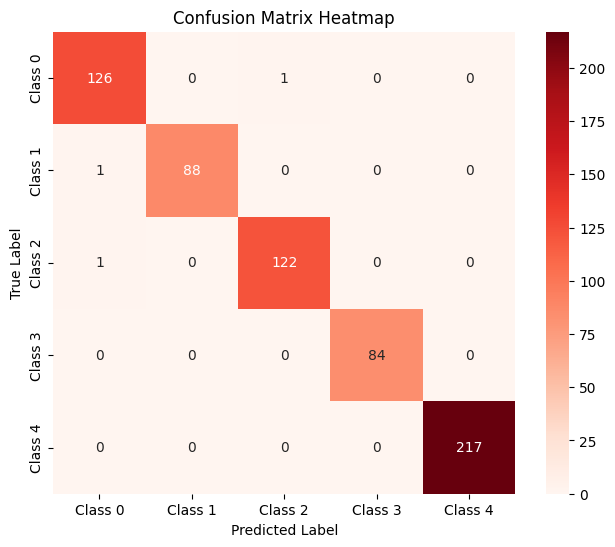

In [25]:
plt.figure(figsize=(8, 6))
class_names = [f'Class {i}' for i in range(len(cm))] 
sb.heatmap(cm, annot=True, square='True', fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [26]:

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0, 0.5, 'Predicted values')

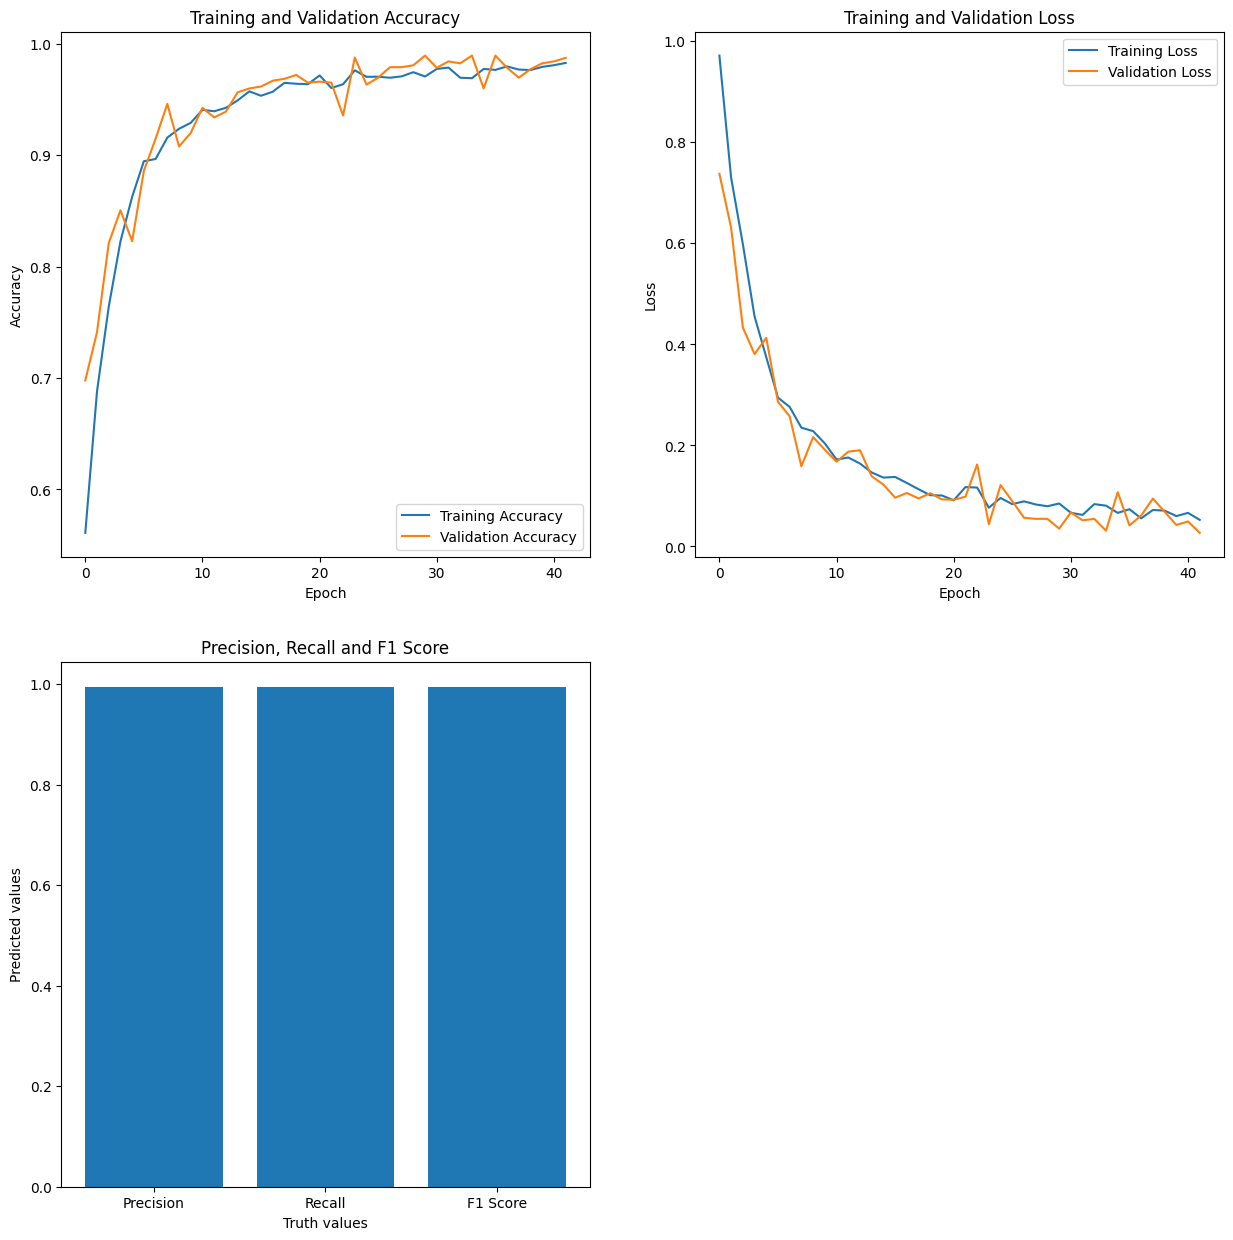

In [28]:


plt.figure(figsize=(15, 15))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), train_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.xticks(np.arange(0, EPOCHS+1, step=5)) 
#plt.yticks(np.arange(0, 1.1, step=0.1)) 

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), train_loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xticks(np.arange(0, EPOCHS+1, step=5))  # Equal divisions on x-axis
#plt.yticks(np.arange(0, max(max(train_loss), max(val_loss))+0.1, step=0.1))  

# Precision, Recall, and F1 Score plot
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']
plt.subplot(2, 2, 3)
plt.bar(metric_names, metrics)
plt.title('Precision, Recall and F1 Score')
plt.xlabel('Truth values')
plt.ylabel('Predicted values')
#plt.ylim(0, 1) 
#plt.yticks(np.arange(0, 1.1, step=0.05))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


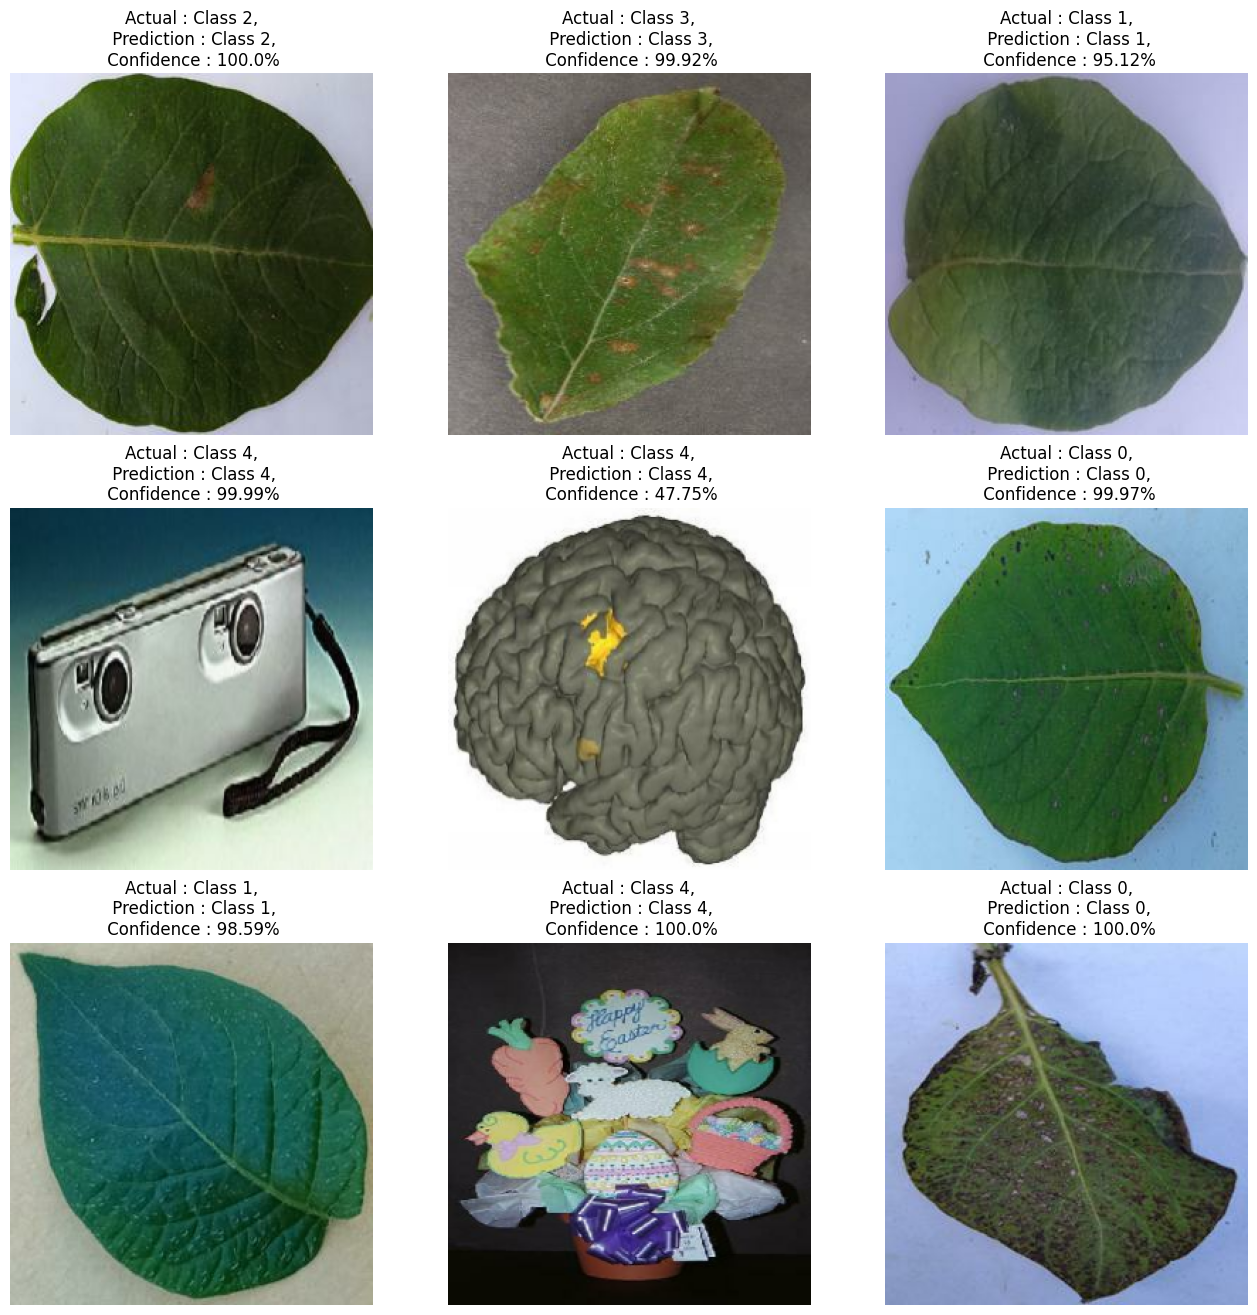

In [29]:
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_pc.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [30]:
unk_lf = tf.keras.preprocessing.image_dataset_from_directory("dataset\\PLD_5_Classes_256\\Testing",
                                                             image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 1584 files belonging to 5 classes.


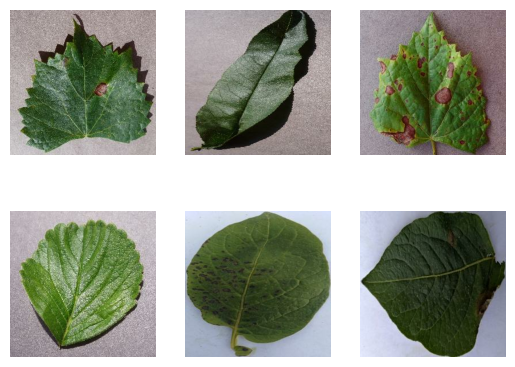

In [31]:
for image_batch, label_batch in unk_lf.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


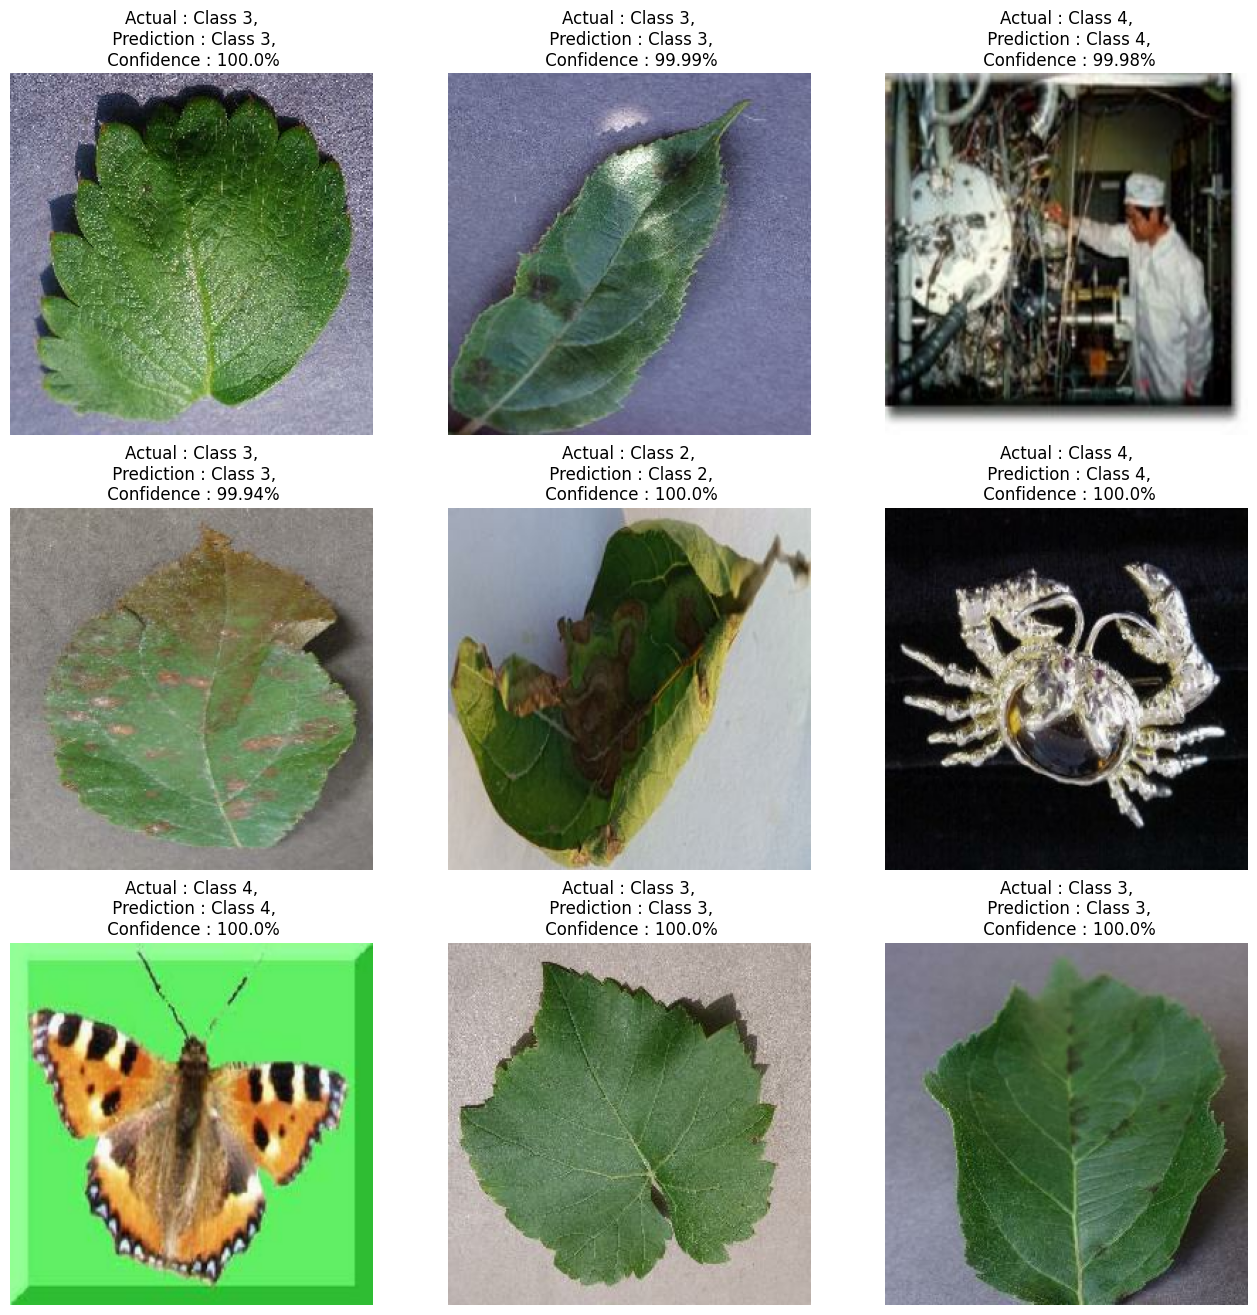

In [33]:
plt.figure(figsize = (16,16))
for batch_image, batch_label in unk_lf.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [34]:
model.save("saved_model_98.15_256.keras")